In [36]:
import scipy.spatial
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import ProjectiveTransform
from skimage.transform import warp
import skimage
import scipy.linalg
plt.rcParams['figure.figsize'] = (16, 9)
%matplotlib notebook

In [55]:
'''
Part2.1
Fit_fundamantal
Normalize
'''
def fit_fundamental(match,normalize = True):
    '''
    Load data.
    We need the matches of two pics.
    '''
    library_matched = match
    #library_matched = np.loadtxt(match)
    num_of_match = library_matched.shape[0]
    match1_temp = library_matched[:,:2]
    match2_temp = library_matched[:,2:]
    
    match1 = np.append(match1_temp, np.ones([len(match1_temp),1]),1)#add additional column of ones
    match2 = np.append(match2_temp, np.ones([len(match2_temp),1]),1)
    if normalize:
        T1,match1 = normalize_2(match1)
        T2,match2 = normalize_2(match2)
    u = match1[:, 0]
    v = match1[:, 1]
    u_p = match2[:, 0]
    v_p = match2[:, 1]
    
    A = np.array([np.multiply(u_p,u),
    np.multiply(u_p,v),
    u_p,
    np.multiply(v_p,u),
    np.multiply(v_p,v),
    v_p,
    u,
    v])
    A_new = np.transpose(A)
    B = np.append(A_new,np.ones([len(A_new),1]),1)
    U, s, V = np.linalg.svd(B)
    
    fundamental_mat = np.reshape(V[-1],(3,3))#assert rank = 2
    U1, s1, V1 = np.linalg.svd(fundamental_mat)
    S_new = np.diag(s1)
    S_new[2][2] = 0
    #V1_new=np.transpose(V1)
    V1_new = V1
    
    temp = np.matmul(U1,S_new)
    F = np.matmul(temp,V1_new)#F is the fundamental matrix
     #Denormalize
    if normalize:
        temp1 = np.matmul(T2.T,F)
        F = np.matmul(temp1, T1)
    
    return F

def normalize_2(match):
    mean = np.mean(match, axis = 0)
    newx = np.zeros(match.shape)
    newx[:,0] = match[:,0] - mean[0]
    newx[:,1] = match[:,1] - mean[1]
    newx = newx**2
    s = np.sum(newx,axis =1)
    newx = np.sqrt(s)
    scale = np.sqrt(2)/np.mean(newx)
    T = np.array([[scale  , 0,   -scale*mean[0]],
         [0 ,    scale ,-scale*mean[1]],
         [0   ,    0   ,   1       ]])
    newmatch = np.matmul(T,match.T)
    
    return T,newmatch.T

def addone(a):
    b=np.append(a,np.ones([len(a),1]),1)
    return b
def get_geo_distance(matches, F):
    """Compute average geometric distances between epipolar line and its 
    corresponding point in both images. Note that matches is all of the 
    matching pair, not the selected ones in fit_fundamental()."""

    ones = np.ones((matches.shape[0], 1))
    all_p1 = np.concatenate((matches[:, 0:2], ones), axis=1)
    all_p2 = np.concatenate((matches[:, 2:4], ones), axis=1)
    # Epipolar lines.
    F_p1 = np.dot(F, all_p1.T).T  # F*p1, dims [#points, 3].
    F_p2 = np.dot(F.T, all_p2.T).T  # (F^T)*p2, dims [#points, 3].
    # Geometric distances.
    p1_line2 = np.sum(all_p1 * F_p2, axis=1)[:, np.newaxis]
    p2_line1 = np.sum(all_p2 * F_p1, axis=1)[:, np.newaxis]
    d1 = np.absolute(p1_line2) / np.linalg.norm(F_p2, axis=1)[:, np.newaxis]
    d2 = np.absolute(p2_line1) / np.linalg.norm(F_p1, axis=1)[:, np.newaxis]

    # Final distance.
    dist1 = d1.sum() / matches.shape[0]
    dist2 = d2.sum() / matches.shape[0]

    return dist1, dist2


<IPython.core.display.Javascript object>


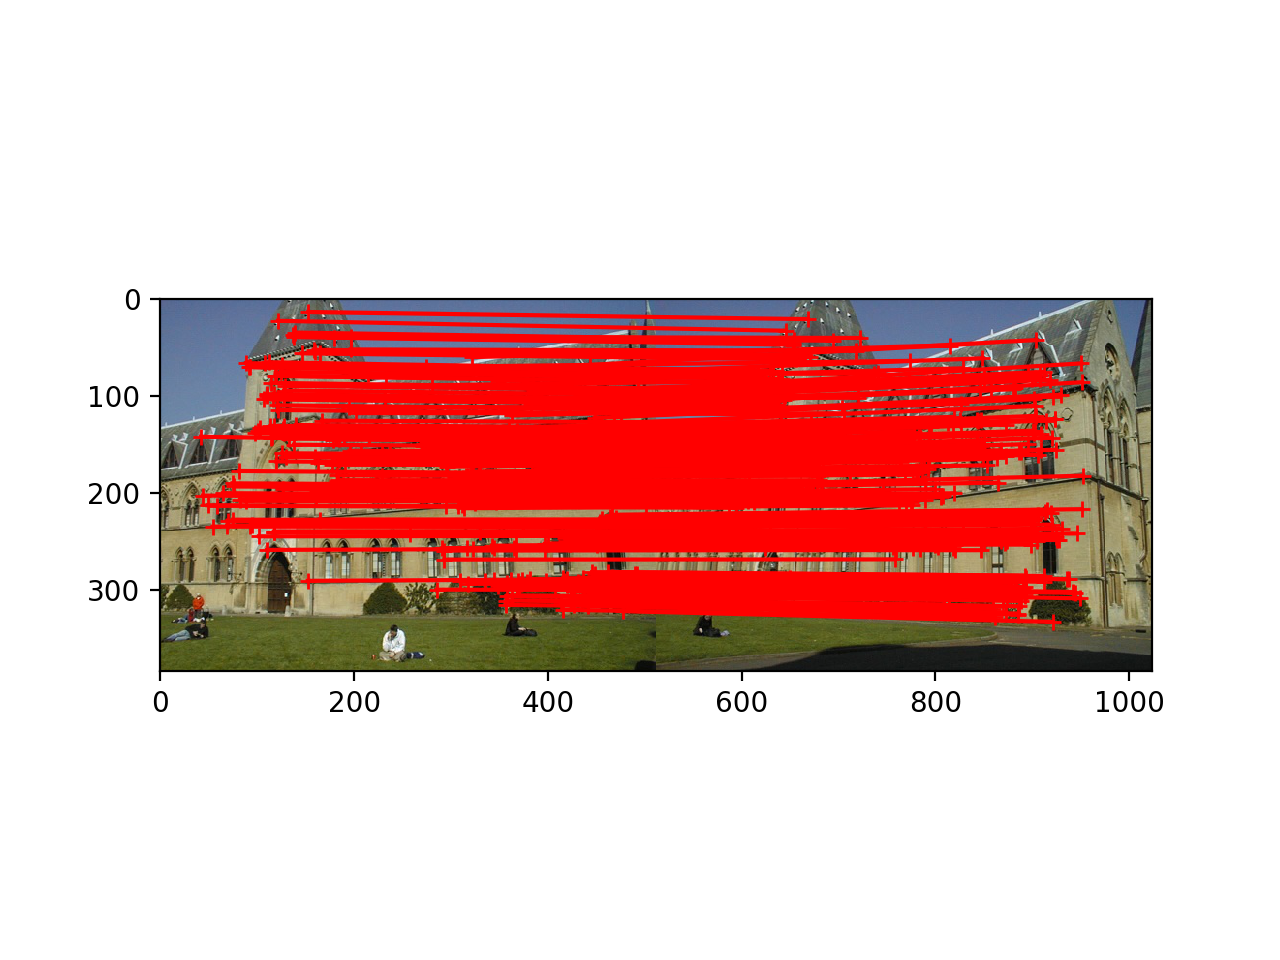

(0.0025197824553156627, 0.0021459109516260852)


<IPython.core.display.Javascript object>


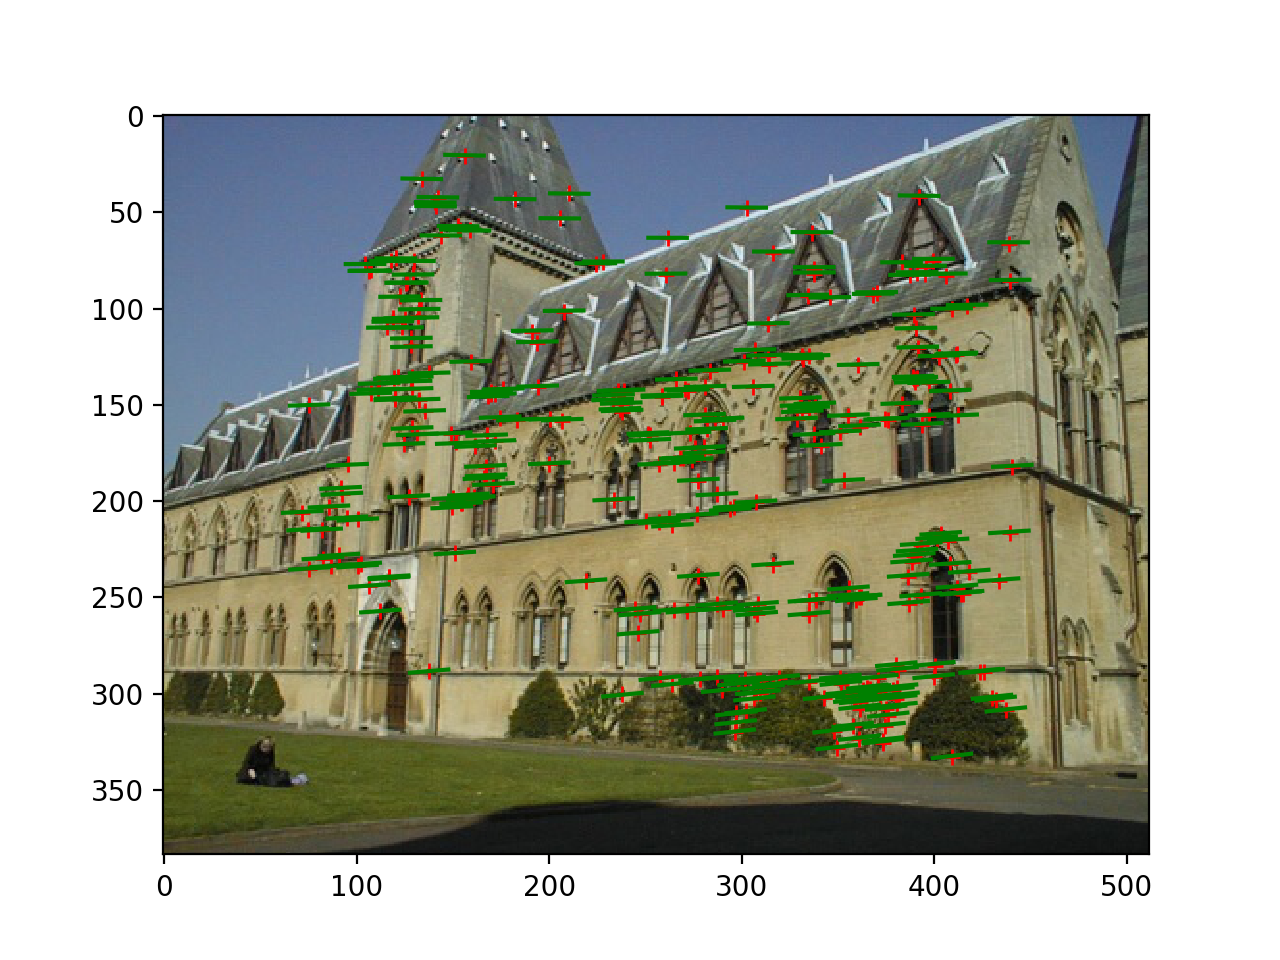

In [58]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

##
## load images and match files for the first example
##

#I1 = Image.open('lab1.jpg');
#I2 = Image.open('lab2.jpg');
#matches = np.loadtxt('lab_matches.txt'); 
I1 = Image.open('library1.jpg');
I2 = Image.open('library2.jpg');
matches = np.loadtxt('library_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3).astype(float)/255)
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()

##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
F= fit_fundamental(matches,False); # this is a function that you should write
d1,d2 = get_geo_distance(matches,F)
print((d1,d2))
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype(float)/255)
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()



In [39]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [72]:
'''
Part2.2 Camera calibration

'''

def camera_calibration(three_d_position, match):
    lab3d = np.loadtxt(three_d_position)
    lab3d = addone(lab3d)
    lab_match = np.loadtxt(match)
    
    match1 = lab_match[:,:2]
    match2 = lab_match[:,2:]
    match1 = addone(match1)
    match2 = addone(match2)
    
    n=match1.shape[0]
    temp_mat = np.zeros((3*n,12))
    
    for i in range(n):
        temp_mat[3*i,:] = np.array([0,0,0,0,lab3d[i][0],lab3d[i][1],lab3d[i][2],lab3d[i][3],
                                   -match1[i][1]*lab3d[i][0],
                                    -match1[i][1]*lab3d[i][1],
                                    -match1[i][1]*lab3d[i][2],
                                    -match1[i][1]*lab3d[i][3]])
        temp_mat[3*i+1,:] = np.array([lab3d[i][0],lab3d[i][1],lab3d[i][2],lab3d[i][3],
                                      0,0,0,0,
                                   -match1[i][0]*lab3d[i][0],
                                    -match1[i][0]*lab3d[i][1],
                                      -match1[i][0]*lab3d[i][2],
                                    -match1[i][0]*lab3d[i][3]])
        temp_mat[3*i+2,:] = np.array([-match1[i][1]*lab3d[i][0],
                                    -match1[i][1]*lab3d[i][1],
                                    -match1[i][1]*lab3d[i][2],
                                    -match1[i][1]*lab3d[i][3],

                                   match1[i][0]*lab3d[i][0],
                                    match1[i][0]*lab3d[i][1],
                                      match1[i][0]*lab3d[i][2],
                                    match1[i][0]*lab3d[i][3],
                                      0,0,0,0,])
        
    U, s, V = np.linalg.svd(temp_mat)
    camera1 = np.reshape(V[-1],(3,4))
    
    temp_mat = np.zeros((3*n,12))
    
    for i in range(n):
        temp_mat[3*i,:] = np.array([0,0,0,0,lab3d[i][0],lab3d[i][1],lab3d[i][2],lab3d[i][3],
                                   -match2[i][1]*lab3d[i][0],
                                    -match2[i][1]*lab3d[i][1],
                                    -match2[i][1]*lab3d[i][2],
                                    -match2[i][1]*lab3d[i][3]])
        temp_mat[3*i+1,:] = np.array([lab3d[i][0],lab3d[i][1],lab3d[i][2],lab3d[i][3],
                                      0,0,0,0,
                                   -match2[i][0]*lab3d[i][0],
                                    -match2[i][0]*lab3d[i][1],
                                      -match2[i][0]*lab3d[i][2],
                                    -match2[i][0]*lab3d[i][3]])
        temp_mat[3*i+2,:] = np.array([-match2[i][1]*lab3d[i][0],
                                    -match2[i][1]*lab3d[i][1],
                                    -match2[i][1]*lab3d[i][2],
                                    -match2[i][1]*lab3d[i][3],

                                   match2[i][0]*lab3d[i][0],
                                    match2[i][0]*lab3d[i][1],
                                      match2[i][0]*lab3d[i][2],
                                    match2[i][0]*lab3d[i][3],
                                      0,0,0,0,])
        
    U, s, V = np.linalg.svd(temp_mat)
    camera2 = np.reshape(V[-1],(3,4))
    return camera1, camera2


In [74]:
c1,c2 = camera_calibration('lab_3d.txt','lab_matches.txt')
print((c1,c2))

(array([[ 3.10740501e-03,  1.38225705e-04, -4.30393249e-04,
        -9.79335944e-01],
       [ 3.02102470e-04,  6.36588396e-04, -2.78063121e-03,
        -2.02191134e-01],
       [ 1.67247027e-06,  2.75156573e-06, -6.60891275e-07,
        -1.32847591e-03]]), array([[-6.95025729e-03,  4.04449978e-03,  1.24803741e-03,
         8.26152566e-01],
       [-1.55403296e-03, -1.01963966e-03,  7.26123346e-03,
         5.63327635e-01],
       [-7.63228489e-06, -3.69298847e-06,  1.80489202e-06,
         3.39276049e-03]]))


In [75]:
lab3d = np.loadtxt('lab_3d.txt')
lab_match = np.loadtxt('lab_matches.txt')
match1 = lab_match[:,:2]
match2 = lab_match[:,2:]

In [81]:
p1,r1 = evaluate_points(c1, match1, lab3d)
distance1 = np.mean(np.linalg.norm(p1-match1))
print((distance1,r1))

(4.537066043038476, 15.004644824550462)


In [89]:
p2,r2 = evaluate_points(c2, match2, lab3d)
distance2 = np.linalg.norm(p2-match2)
print((distance2,r2))

(4.160951586228948, 16.944223599302973)


In [94]:
'''
Part2.3 Camera center
'''
import numpy as np
from numpy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D


def rank(A, atol=1e-13, rtol=0):
    """Estimate the rank (i.e. the dimension of the nullspace) of a matrix.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length n will be treated
        as a 2-D with shape (1, n)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    r : int
        The estimated rank of the matrix.

    See also
    --------
    numpy.linalg.matrix_rank
        matrix_rank is basically the same as this function, but it does not
        provide the option of the absolute tolerance.
    """

    A = np.atleast_2d(A)
    s = svd(A, compute_uv=False)
    tol = max(atol, rtol * s[0])
    rank = int((s >= tol).sum())
    return rank


def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns
def camera_center(P1, P2):
    #P1 = np.loadtxt(cam1)#load camera
    #P2 = np.loadtxt(cam2)
    C1 = nullspace(P1)
    C1 = C1[0:3,:]
    C1 = C1 / C1[-1]
    C2 = nullspace(P2)
    C2 = C2[0:3,:]
    C2 = C2 / C2[-1]
    print(C1[0], C1[1], C1[2])
    print(C2[0], C2[1], C2[2])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(C1[0], C1[1], C1[2], 'r')#camera center1
    ax.scatter(C2[0], C2[1], C2[2], 'r')#camera center2
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
    
    return 0

[9.96298887] [10.09770521] [1.]
[10.14412157] [10.08984463] [1.]


<IPython.core.display.Javascript object>


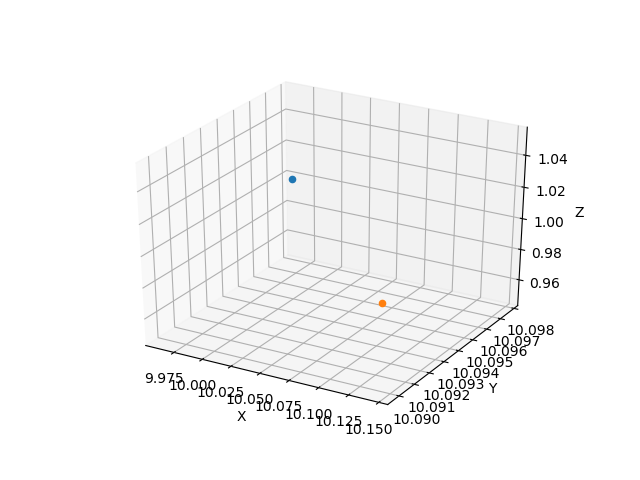

0

In [95]:
camera_center(labcam1,labcam2)

In [127]:
'''
Part2.4 Triangulation
'''
from scipy.spatial import distance
def triangulate(cam1, cam2, match):
    P1 = np.loadtxt(cam1)#load camera and match
    P2 = np.loadtxt(cam2)
    match1 = np.loadtxt(match)
    num_of_match = match1.shape[0]
    
    C1 = nullspace(P1)
    C1 = C1[0:3,:]
    C1 = C1 / C1[-1]
    C2 = nullspace(P2)
    C2 = C2[0:3,:]
    C2 = C2 / C2[-1]
    coords_3d = np.zeros((num_of_match, 3))
    for i in range(num_of_match):
        x1 = [[0,-1,match1[i,1]],[1,0,-match1[i,0]],[-match1[i,1],match1[i,0],0]]
        x2 = [[0,-1,match1[i,3]],[1,0,-match1[i,2]],[-match1[i,3],match1[i,2],0]]
        D = np.concatenate( (np.matmul(x1,P1),np.matmul(x2,P2)))
        U,s,V = np.linalg.svd(D)

        X = V[-1]

        coords_3d[i] = [X[0]/X[3],X[1]/X[3],X[2]/X[3]]
        
    #plt.plot(coords_3d[:,0], coords_3d[:, 1], coords_3d[:, 2])
    #plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

   
    xs = coords_3d[:,0]
    ys = coords_3d[:, 1]
    zs = coords_3d[:, 2]
    ax.scatter(xs, ys, zs)
    ax.scatter(C1[0], C1[1], C1[2], 'r')#camera center1
    ax.scatter(C2[0], C2[1], C2[2], 'b')#camera center2
    

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
    ones = np.ones((coords_3d.shape[0], 1))
    X_3d = np.concatenate((coords_3d, ones), axis=1)
    projected1 = np.dot(P1, X_3d.T).T
    projected1 = projected1 / projected1[:, -1][:, np.newaxis]
    projected2 = np.dot(P2, X_3d.T).T
    projected2 = projected2 / projected2[:, -1][:, np.newaxis]
    # Compute residual.
    res1 = np.linalg.norm(projected1[:, 0:2]-match1[:, 0:2]) ** 2
    res2 = np.linalg.norm(projected2[:, 0:2]-match1[:, 2:4]) ** 2
    # avg_res = (res1 + res2) / 2 / matches.shape[0]

    avg_res1 = res1 / matches.shape[0]
    avg_res2 = res2 / matches.shape[0]
    return coords_3d,avg_res1,avg_res2

<IPython.core.display.Javascript object>


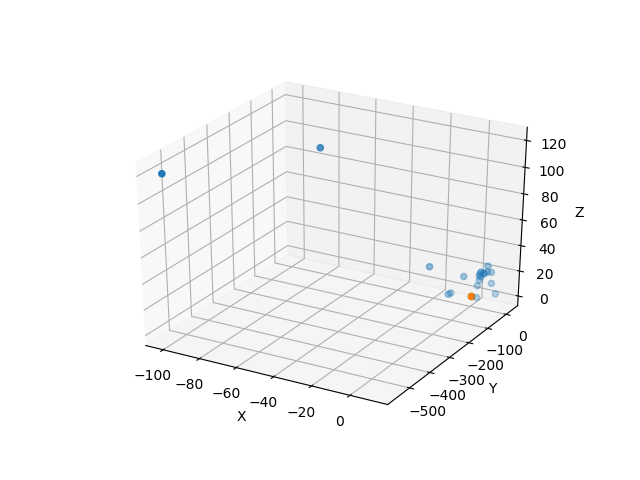

In [128]:
coord_3d,r1,r2 = triangulate('library1_camera.txt','library2_camera.txt','lab_matches.txt')

In [129]:
print((r1,r2))

(239.28105902896687, 1539.8185688579103)


In [46]:
labcam1 = np.array([[ 3.10740501e-03,  1.38225705e-04, -4.30393249e-04,-9.79335944e-01],
                    [ 3.02102470e-04,  6.36588396e-04, -2.78063121e-03,-2.02191134e-01],
                    [ 1.67247027e-06,  2.75156573e-06, -6.60891275e-07,-1.32847591e-03]])
labcam2 = np.array([[-6.95025729e-03,  4.04449978e-03,  1.24803741e-03,8.26152566e-01],
                    [-1.55403296e-03, -1.01963966e-03,  7.26123346e-03,5.63327635e-01],
                    [-7.63228489e-06, -3.69298847e-06,  1.80489202e-06,3.39276049e-03]])

[0.41097354] [-1.21348394] [1.]
[0.29442916] [-0.65737074] [1.]


<IPython.core.display.Javascript object>


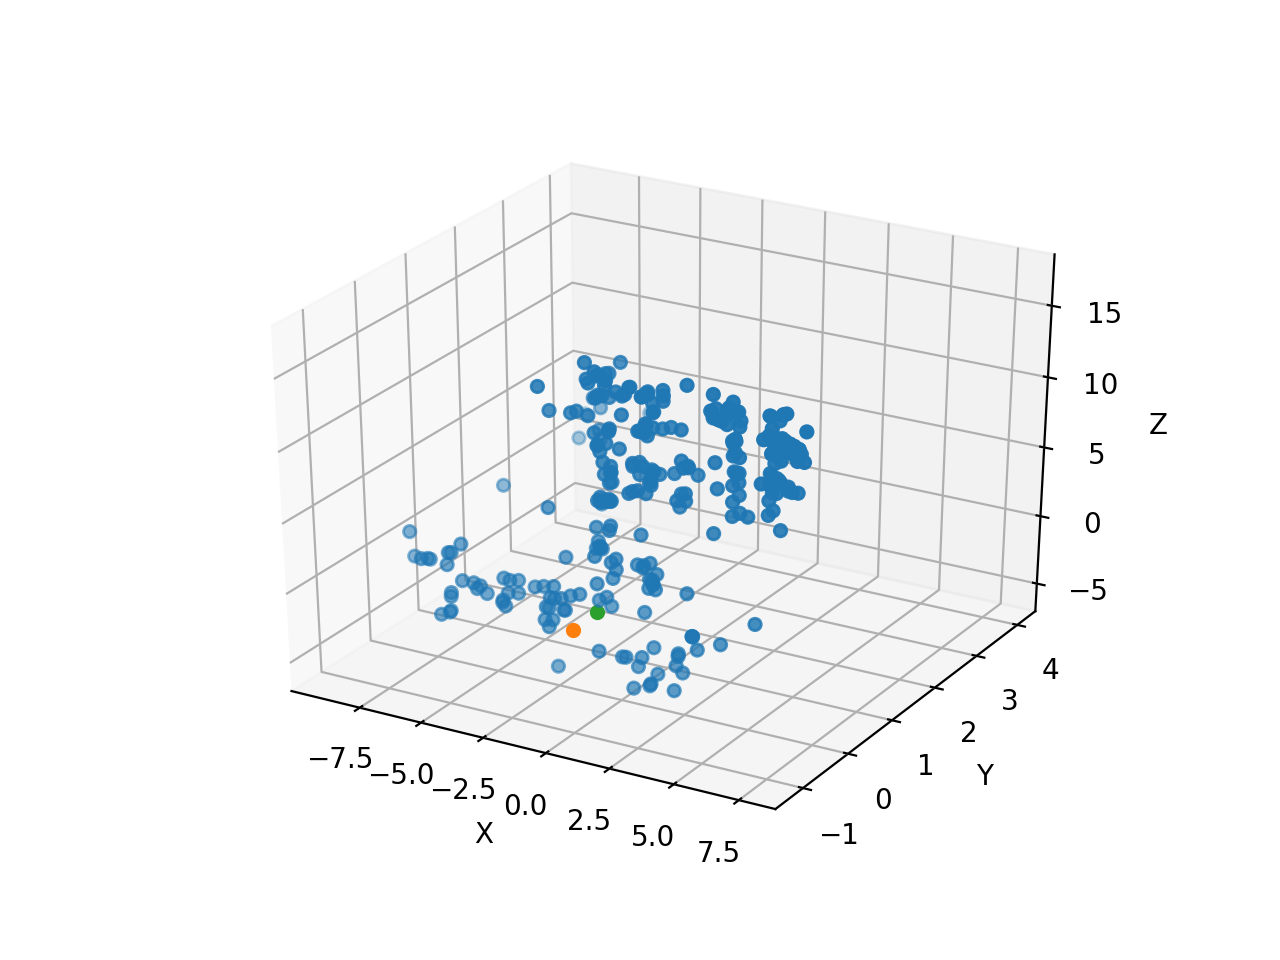

(51.53227122130176, 81.28132134991893, 309)

In [47]:
triangulate('library1_camera.txt','library2_camera.txt','library_matches.txt')

In [137]:
def triangulate_test(match):
    P2 = np.array([[-6.95025729e-03,  4.04449978e-03,  1.24803741e-03,
         8.26152566e-01],
       [-1.55403296e-03, -1.01963966e-03,  7.26123346e-03,
         5.63327635e-01],
       [-7.63228489e-06, -3.69298847e-06,  1.80489202e-06,
         3.39276049e-03]])
    P1 = np.array([[ 3.10740501e-03,  1.38225705e-04, -4.30393249e-04,
        -9.79335944e-01],
       [ 3.02102470e-04,  6.36588396e-04, -2.78063121e-03,
        -2.02191134e-01],
       [ 1.67247027e-06,  2.75156573e-06, -6.60891275e-07,
        -1.32847591e-03]])
    P1 = P1/P1[2][3]
    P2 = P2/P2[2][3]

    match1 = np.loadtxt(match)
    num_of_match = match1.shape[0]
    
    C1 = nullspace(P1)
    C1 = C1[0:3,:]
    C1 = C1 / C1[-1]
    C2 = nullspace(P2)
    C2 = C2[0:3,:]
    C2 = C2 / C2[-1]
    print(C1[0], C1[1], C1[2])
    print(C2[0], C2[1], C2[2])
    coords_3d = np.zeros((num_of_match, 3))
    for i in range(num_of_match):
        x1 = [[0,-1,match1[i,1]],[1,0,-match1[i,0]],[-match1[i,1],match1[i,0],0]]
        x2 = [[0,-1,match1[i,3]],[1,0,-match1[i,2]],[-match1[i,3],match1[i,2],0]]
        D = np.concatenate( (np.matmul(x1,P1),np.matmul(x2,P2)))
        U,s,V = np.linalg.svd(D)

        X = V[-1]

        coords_3d[i] = [X[0]/X[3],X[1]/X[3],X[2]/X[3]]
        
    #plt.plot(coords_3d[:,0], coords_3d[:, 1], coords_3d[:, 2])
    #plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

   
    xs = coords_3d[:,0]
    ys = coords_3d[:, 1]
    zs = coords_3d[:, 2]
    ax.scatter(xs, ys, zs)
    ax.scatter(C1[0], C1[1], C1[2], 'r')#camera center1
    ax.scatter(C2[0], C2[1], C2[2], 'b')#camera center2
    

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

    r1 = r2 = 0#calculate residual
    
    for i in range(num_of_match):
        X1 = np.matmul(P1, np.append(coords_3d[i] , 1))
        r1 += np.linalg.norm(np.array([X1[0]/X1[2], X1[1]/X1[2]])-
                             np.array([match1[i, 0],match1[i, 1]]))**2
        X2 = np.matmul(P2, np.append(coords_3d[i] , 1))
        r2 += np.linalg.norm(np.array([X2[0]/X2[2], X2[1]/X2[2]])-
                             np.array([match1[i, 2],match1[i, 3]]))**2
        
    return r1/num_of_match, r2/num_of_match, num_of_match,coords_3d

[10.14412157] [10.08984463] [1.]
[9.96298887] [10.09770521] [1.]


<IPython.core.display.Javascript object>


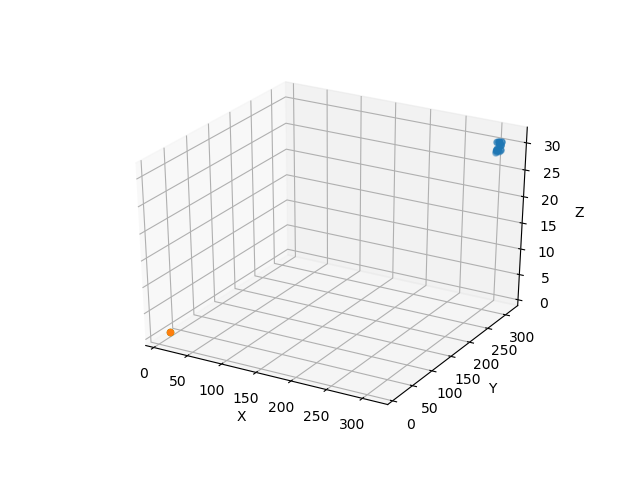

(0.5259530450808834,
 0.5837138295029038,
 20,
 array([[312.7526932 , 309.14431262,  30.08966338],
        [305.78758907, 311.64389818,  30.36089021],
        [307.70457574, 312.38044079,  30.41758194],
        [310.14226202, 307.1800686 ,  29.29880465],
        [311.92750558, 310.10724072,  29.21990907],
        [311.21745788, 307.57619681,  30.68123001],
        [307.10295787, 306.8788875 ,  28.6600083 ],
        [309.29598655, 312.45186058,  30.22583364],
        [307.43746295, 310.14410892,  29.31580395],
        [308.2466842 , 306.29474106,  28.88313566],
        [306.63815543, 309.28721844,  28.9106886 ],
        [308.07124635, 306.83713409,  29.18928807],
        [309.63897763, 308.8089709 ,  29.03527232],
        [308.26988268, 309.97152742,  29.26409152],
        [307.57355028, 308.62878742,  28.96253747],
        [311.04558218, 309.2077114 ,  28.90594757],
        [307.52520523, 308.18751853,  29.06562287],
        [309.94757388, 311.25772521,  29.98825629],
        [312.1884

In [145]:
triangulate_test('lab_matches.txt')

In [139]:
def triangulate_test2(P1,P2,match):
    P1 = P1/P1[2][3]
    P2 = P2/P2[2][3]

    match1 = np.loadtxt(match)
    num_of_match = match1.shape[0]
    
    C1 = nullspace(P1)
    C1 = C1[0:3,:]
    C1 = C1 / C1[-1]
    C2 = nullspace(P2)
    C2 = C2[0:3,:]
    C2 = C2 / C2[-1]
    print(C1[0], C1[1], C1[2])
    print(C2[0], C2[1], C2[2])
    coords_3d = np.zeros((num_of_match, 3))
    for i in range(num_of_match):
        x1 = [[0,-1,match1[i,1]],[1,0,-match1[i,0]],[-match1[i,1],match1[i,0],0]]
        x2 = [[0,-1,match1[i,3]],[1,0,-match1[i,2]],[-match1[i,3],match1[i,2],0]]
        D = np.concatenate( (np.matmul(x1,P1),np.matmul(x2,P2)))
        U,s,V = np.linalg.svd(D)

        X = V[-1]

        coords_3d[i] = [X[0]/X[3],X[1]/X[3],X[2]/X[3]]
        
    #plt.plot(coords_3d[:,0], coords_3d[:, 1], coords_3d[:, 2])
    #plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

   
    xs = coords_3d[:,0]
    ys = coords_3d[:, 1]
    zs = coords_3d[:, 2]
    ax.scatter(xs, ys, zs)
    ax.scatter(C1[0], C1[1], C1[2], 'r')#camera center1
    ax.scatter(C2[0], C2[1], C2[2], 'b')#camera center2
    

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

    r1 = r2 = 0#calculate residual
    
    for i in range(num_of_match):
        X1 = np.matmul(P1, np.append(coords_3d[i] , 1))
        r1 += np.linalg.norm(np.array([X1[0]/X1[2], X1[1]/X1[2]])-
                             np.array([match1[i, 0],match1[i, 1]]))**2
        X2 = np.matmul(P2, np.append(coords_3d[i] , 1))
        r2 += np.linalg.norm(np.array([X2[0]/X2[2], X2[1]/X2[2]])-
                             np.array([match1[i, 2],match1[i, 3]]))**2
        
    return r1/num_of_match, r2/num_of_match, num_of_match,coords_3d

In [140]:
libcam1 = np.loadtxt('library1_camera.txt')
libcam2 = np.loadtxt('library2_camera.txt')

[0.41097354] [-1.21348394] [1.]
[0.29442916] [-0.65737074] [1.]


<IPython.core.display.Javascript object>


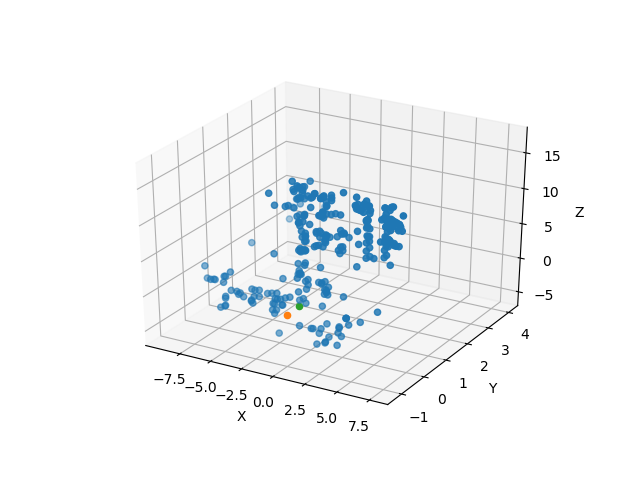

In [142]:
r1, r2,num_of_match,coords_3d =  triangulate_test2(libcam1,libcam2,'library_matches.txt')

In [143]:
print((r1,r2))

(0.0732514127606393, 0.26751804066735635)
